In [1]:
import tensorflow as tf
from tensorflow import keras
import ipywidgets

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  0
2.9.1


2023-01-18 17:02:51.806864: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-18 17:02:51.806946: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gradinstance1): /proc/driver/nvidia/version does not exist


'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [3]:
# ! pip install opencv-python

## Imports

In [4]:
import os
import io
import matplotlib.pyplot as plt
import cv2
import imageio
#import medmnist
#import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2 as cv

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
np.random.seed(SEED)

## Hyperparameters

The hyperparameters are chosen via hyperparameter
search. You can learn more about the process in the "conclusion" section.

In [5]:
# DATA
DATASET_NAME = "UCF-Crime-mini"
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (15, 100, 100, 1)
NUM_CLASSES = 13
TRAIN_RATIO = 0.7
TEST_RATIO = 0.25
VALIDATION_RATIO = 0.05

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [6]:
ROOT_PATH = "../datasets/ucf-crime-mini/dataset"

Abuse_PATH = ROOT_PATH + '/Abuse'
Arrest_PATH = ROOT_PATH + '/Arrest'
Assault_PATH = ROOT_PATH + '/Assault'
Burglary_PATH = ROOT_PATH + '/Burglary'
Fighting_PATH = ROOT_PATH + '/Fighting'
Normal_PATH = ROOT_PATH + '/normal'



OUT_PATH = "../out/vivit-ucf-mini/"

In [12]:
def extract_frames(directory, dimensions=(INPUT_SHAPE[1], INPUT_SHAPE[2]), packet_length = INPUT_SHAPE[0], save_dir_path = None):
    data = []

    for video_name in os.listdir(directory):
        video = cv2.VideoCapture(directory + '/' + video_name)
        packet = np.zeros((packet_length,)+dimensions)
        count = 0
        while video.isOpened():
            ret, frame = video.read()

            if not ret: # no more frames
                break

            del ret

            # capturing the frame

            frame = cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            packet[count] = frame
            count = count + 1
            del frame

            if count == packet_length: 
                '''
                consecutive packets share 14 of the 15 frames to generate more data
                '''
                # packet itself is not normalized
                stacked = np.array(packet) # convert to numpy and normalize packet
                data.append(stacked.copy()) # this .copy() is not in the original code 
                # del packet
                half_packet = packet[int(packet_length / 2 + 1):]
                packet = np.zeros((packet_length,)+dimensions)
                packet[:int(packet_length / 2)] = half_packet
                count = 7


        video.release()
        cv2.destroyAllWindows()

    del packet
    data = np.stack(data, axis= 0)
#     data = np.moveaxis(data, 1 ,-1)

    # save to disk
    if(save_dir_path is not None):
        np.save(f'{save_dir_path}/data', data)

    return data

In [13]:
normal_frames   = extract_frames(Normal_PATH)
abuse_frames    = extract_frames(Abuse_PATH)
arrest_frames   = extract_frames(Arrest_PATH)
assault_frames  = extract_frames(Assault_PATH)
burglary_frames = extract_frames(Burglary_PATH)
fighting_frames = extract_frames(Fighting_PATH)
print(normal_frames.shape)


(2400, 15, 100, 100)


In [14]:
all_frames = {
    'normal'  :normal_frames,
    'abuse'   :abuse_frames,
    'arrest'  :arrest_frames,
    'assault' :assault_frames,
    'burglary':burglary_frames,
    'fighting':fighting_frames,
}
min_frames = np.inf

for _ ,v in all_frames.items():
    if v.shape[0] < min_frames:
        min_frames = v.shape[0]

print(min_frames) 

for k, _ in all_frames.items():
    all_frames[k] = all_frames[k][:min_frames]
    


1089


In [15]:
all_labels = {}
count = 0
for k,v in all_frames.items():
    all_labels[k] = np.full((v.shape[0]),count)
    count = count + 1

In [16]:
train_size = int(min_frames * 0.7)
val_size   = int(min_frames * 0.75)
# test_size  = int(min_frames * 0.25)

train_frames = {}
train_labels = {}
val_frames   = {}
val_labels   = {}
test_frames  = {}
test_labels  = {}

for k, v in all_frames.items():
    train_frames[k] = v[:train_size]
    train_labels[k] = all_labels[k][:train_size]
    
    val_frames[k]   = v[train_size:val_size]
    val_labels[k]   = all_labels[k][train_size:val_size]
    
    test_frames[k]  = v[val_size:]
    test_labels[k]  = all_labels[k][val_size:]

X_train = train_frames['normal']
y_train = train_labels['normal']
X_val   = val_frames['normal']
y_val   = val_labels['normal']
X_test  = test_frames['normal']
y_test  = test_labels['normal']

for k, v in all_frames.items(): 
    if k == 'normal':
        continue
    X_train = np.concatenate((X_train,train_frames[k]))
    y_train = np.concatenate((y_train,train_labels[k]))

    X_test  = np.concatenate((X_test, test_frames[k]))
    y_test  = np.concatenate((y_test, test_labels[k]))

    X_val   = np.concatenate((X_val, val_frames[k]))
    y_val   = np.concatenate((y_val, val_labels[k]))

In [17]:
del all_frames, all_labels, train_frames, train_labels, test_frames, test_labels, val_frames, val_labels

In [24]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val  ,return_counts=True))
print(np.unique(y_test ,return_counts=True))


(array([0, 1, 2, 3, 4, 5]), array([762, 762, 762, 762, 762, 762]))
(array([0, 1, 2, 3, 4, 5]), array([54, 54, 54, 54, 54, 54]))
(array([0, 1, 2, 3, 4, 5]), array([273, 273, 273, 273, 273, 273]))


(-0.5, 99.5, 99.5, -0.5)

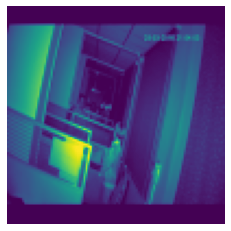

In [25]:
plt.imshow(normal_frames[0][1])
plt.axis('off')

## Extracting frames for 6 classes

In [13]:
'''
Abuse_frames = np.load(r"G:\UCF-crime\Abuse_frames.npy")
Arrest_frames = np.load(r"G:\UCF-crime\Arrest_frames.npy")
Assault_frames = np.load(r"G:\UCF-crime\Assault_frames.npy")
Burglary_frames = np.load(r"G:\UCF-crime\Burglary_frames.npy")
Explosion_frames = np.load(r"G:\UCF-crime\Explosion_frames.npy")
Fighting_frames = np.load(r"G:\UCF-crime\Fighting_frames.npy")
RoadAccidents_frames = np.load(r"G:\UCF-crime\RoadAccidents_frames.npy")
Robbery_frames = np.load(r"G:\UCF-crime\Robbery_frames.npy")
Shooting_frames = np.load(r"G:\UCF-crime\Shooting_frames.npy")
Shoplifting_frames = np.load(r"G:\UCF-crime\Shoplifting_frames.npy")
Stealing_frames = np.load(r"G:\UCF-crime\Stealing_frames.npy")
Vandalism_frames = np.load(r"G:\UCF-crime\Vandalism_frames.npy")
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 28-31: truncated \UXXXXXXXX escape (3298918565.py, line 1)

In [ ]:
# Abuse_frames = extract_frames(Abuse_PATH)
# print(Abuse_frames.shape)
# np.save(r"G:\UCF-crime\Abuse_frames", Abuse_frames)

In [ ]:
# Arrest_frames = extract_frames(Arrest_PATH)
# print(Arrest_frames.shape)
# np.save(r"G:\UCF-crime\Arrest_frames", Arrest_frames)

In [ ]:
# Assault_frames = extract_frames(Assault_PATH)
# print(Assault_frames.shape)
# np.save(r"G:\UCF-crime\Assault_frames", Assault_frames)

In [ ]:
#Burglary_frames = extract_frames(Burglary_PATH)
#print(Burglary_frames.shape)
#np.save(r"G:\UCF-crime\Burglary_frames", Burglary_frames)

In [ ]:
#Fighting_frames = extract_frames(Fighting_PATH)
#print(Fighting_frames.shape)
#np.save(r"G:\UCF-crime\Fighting_frames", Fighting_frames)

# Loading frames

# Data split

In [ ]:
# x = normal_frames.copy()
# del normal_frames

In [ ]:
# x = np.concatenate((x,fighting_frames))
# del fighting_frames

: 

: 

In [11]:
import gc
for i in range(5):
    gc.collect()

In [26]:
print( X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(4572, 15, 100, 100) (1638, 15, 100, 100) (324, 15, 100, 100) (4572,) (1638,) (324,)


0 (4572, 15, 100, 100)


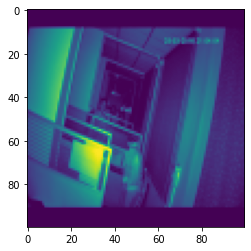

In [27]:
print(y_train[3], X_train.shape)
plt.imshow(X_train[3][0])
plt.show()

### `tf.data` pipeline

In [28]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [29]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels,
                 to_fit=True, batch_size=128, dim=(15, 100, 100),
                 n_channels=1, n_classes=13, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_grayscale_image(self.image_path + self.labels[ID])

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_grayscale_image(self.mask_path + self.labels[ID])

        return y
training_generator = DataGenerator(X_train, y_train)
validation_generator = DataGenerator(X_val, y_val)

In [30]:
len(training_generator)

35

In [31]:
X_val.shape, y_train.shape

((324, 15, 100, 100), (4572,))

In [32]:

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


In [33]:

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


In [34]:

def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [66]:
model_checkpoint = ModelCheckpoint("../checkpoints/vivit-mini-ucf/weights.{epoch:02d}.hdf5",
                monitor='val_loss',
                save_weights_only=True,
                save_best_only=True)

In [65]:
gc.collect()

6451

## Train

In [67]:

def run_experiment():
    mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/cpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    with mirrored_strategy.scope():
    # Initialize model
        model = create_vivit_classifier(
            tubelet_embedder=TubeletEmbedding(
                embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
            ),
            positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
        )

        # Compile the model with the optimizer, loss function
        # and the metrics.
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )

        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')

        # Train the model.
        history = model.fit(X_train,y_train, epochs=EPOCHS, validation_data=(X_val,y_val), callbacks=[model_checkpoint,early_stopping])

        # _, accuracy, top_5_accuracy = model.evaluate(testloader)
        # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
        # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history


model, history = run_experiment()

Epoch 1/60


2023-01-18 17:58:45.495418: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_182116"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:371"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

143/143 [==============================] - ETA: 0s - loss: 1.3972 - accuracy: 0.4547 - top-5-accuracy: 0.9788

2023-01-18 18:00:55.765808: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_193994"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:399"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

143/143 [==============================] - 138s 895ms/step - loss: 1.3972 - accuracy: 0.4547 - top-5-accuracy: 0.9788 - val_loss: 2.5206 - val_accuracy: 0.2191 - val_top-5-accuracy: 0.8765
Epoch 2/60
143/143 [==============================] - ETA: 0s - loss: 1.0404 - accuracy: 0.6430 - top-5-accuracy: 0.9983

2023-01-18 18:03:04.091765: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


143/143 [==============================] - 124s 866ms/step - loss: 1.0404 - accuracy: 0.6430 - top-5-accuracy: 0.9983 - val_loss: 2.1948 - val_accuracy: 0.5000 - val_top-5-accuracy: 0.8673
Epoch 3/60
143/143 [==============================] - ETA: 0s - loss: 0.7268 - accuracy: 0.7946 - top-5-accuracy: 0.9948

2023-01-18 18:05:07.683921: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


143/143 [==============================] - 123s 863ms/step - loss: 0.7268 - accuracy: 0.7946 - top-5-accuracy: 0.9948 - val_loss: 2.5224 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8796
Epoch 4/60
143/143 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8858 - top-5-accuracy: 0.9954

2023-01-18 18:07:10.664781: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


143/143 [==============================] - 123s 860ms/step - loss: 0.4533 - accuracy: 0.8858 - top-5-accuracy: 0.9954 - val_loss: 2.1057 - val_accuracy: 0.6975 - val_top-5-accuracy: 0.8765
Epoch 5/60
143/143 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9418 - top-5-accuracy: 0.9983

2023-01-18 18:09:14.103780: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


143/143 [==============================] - 123s 863ms/step - loss: 0.2310 - accuracy: 0.9418 - top-5-accuracy: 0.9983 - val_loss: 2.1174 - val_accuracy: 0.6481 - val_top-5-accuracy: 0.8765
Epoch 6/60
143/143 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9742 - top-5-accuracy: 0.9985

2023-01-18 18:11:17.527746: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


143/143 [==============================] - 123s 863ms/step - loss: 0.1059 - accuracy: 0.9742 - top-5-accuracy: 0.9985 - val_loss: 2.1464 - val_accuracy: 0.7840 - val_top-5-accuracy: 0.8765
Epoch 7/60
143/143 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9926 - top-5-accuracy: 0.9996

2023-01-18 18:13:20.418738: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


143/143 [==============================] - 123s 860ms/step - loss: 0.0406 - accuracy: 0.9926 - top-5-accuracy: 0.9996 - val_loss: 2.1944 - val_accuracy: 0.8272 - val_top-5-accuracy: 0.8796


In [58]:
model = create_vivit_classifier(
    tubelet_embedder=TubeletEmbedding(
        embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
    ),
    positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
)

# Compile the model with the optimizer, loss function
# and the metrics.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

model.load_weights("../checkpoints/vivit-mini-ucf/weights.hdf5")

ValueError: Layer count mismatch when loading weights from file. Model expected 36 layers, found 0 saved layers.

Text(0.5, 0, 'Epochs ')

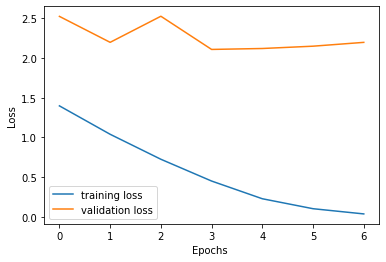

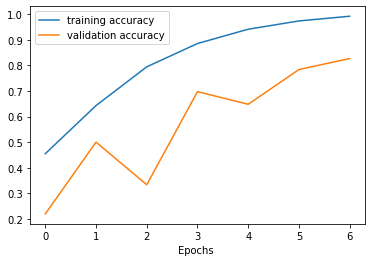

In [68]:
num=len(history.history['loss'])

plt.plot(range(num),history.history['loss'],label = 'training loss')
plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

plt.legend()

plt.xlabel("Epochs ")
plt.ylabel('Loss')

plt.figure()

plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

plt.legend()
plt.xlabel("Epochs ")

## Inference

In [69]:
model.evaluate(X_val,y_val)

2023-01-18 18:14:13.170340: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_203017"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:496"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

11/11 [==============================] - 3s 259ms/step - loss: 2.1944 - accuracy: 0.8272 - top-5-accuracy: 0.8796


[2.194444179534912, 0.8271604776382446, 0.8796296119689941]

In [70]:
model.evaluate(X_test,y_test)


2023-01-18 18:14:24.567424: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_203252"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:521"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

52/52 [==============================] - 15s 281ms/step - loss: 3.9705 - accuracy: 0.3926 - top-5-accuracy: 0.7827


[3.970493793487549, 0.39255189895629883, 0.7826617956161499]

In [71]:
from sklearn.metrics import f1_score, classification_report

y_pred = np.argmax(model.predict(X_test),axis=-1)
f1_score(y_test, y_pred, average='micro')

target_names = [
    "normal",
    "abuse",
    "arrest",
    "assault",
    "burglary",
    "fighting",
]


print(classification_report(y_test, y_pred, target_names=target_names))

2023-01-18 18:14:45.465982: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_203732"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:546"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

52/52 [==============================] - 16s 276ms/step
              precision    recall  f1-score   support

      normal       0.53      0.04      0.07       273
       abuse       0.47      0.75      0.58       273
      arrest       0.52      1.00      0.68       273
     assault       0.09      0.10      0.09       273
    burglary       0.37      0.48      0.42       273
    fighting       0.00      0.00      0.00       273

    accuracy                           0.39      1638
   macro avg       0.33      0.39      0.31      1638
weighted avg       0.33      0.39      0.31      1638



/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [68]:
! pip install seaborn

In [72]:
np.save("../out/vivit-ucf-mini/y_train",y_train)
np.save("../out/vivit-ucf-mini/y_test",y_test)
np.save("../out/vivit-ucf-mini/y_val",y_val)
np.save("../out/vivit-ucf-mini/y_pred",y_pred)

np.save("../out/vivit-ucf-mini/X_train",X_train)
np.save("../out/vivit-ucf-mini/X_test",X_test)
np.save("../out/vivit-ucf-mini/X_val",X_val)


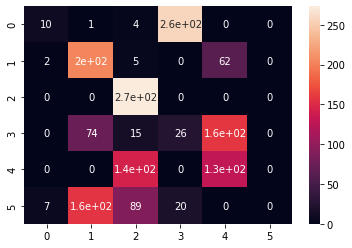

In [1]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix as cm

y_pred = np.load("../out/vivit-ucf-mini/y_pred.npy")
y_test = np.load("../out/vivit-ucf-mini/y_test.npy")
conf = cm(y_test,y_pred)

sns.heatmap(conf,annot=True)